# Import Dataset

In [2]:
import pandas as pd

df = pd.read_csv("alzheimers_disease_data.csv")

# Descriptive Data Analysis

In [3]:
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [4]:
df.columns

Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
       'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
       'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
       'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
       'Forgetfulness', 'Diagnosis', 'DoctorInCharge'],
      dtype='object')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def detect_column_types(df, class_col):
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    num_cols = [col for col in num_cols if col != class_col]
    cat_cols = [col for col in cat_cols if col != class_col]
    return num_cols, cat_cols

def generate_basic_eda_plots(df, class_col='diagnosis'):
    sns.set(style='whitegrid')
    num_cols, cat_cols = detect_column_types(df, class_col)
    
    # 1. Histograms
    for col in num_cols:
        plt.figure(figsize=(5, 4))
        df[col].hist(bins=30)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

    # 2. Boxplots by class
    for col in num_cols:
        plt.figure(figsize=(5, 4))
        sns.boxplot(x=class_col, y=col, data=df)
        plt.title(f'{col} by {class_col}')
        plt.tight_layout()
        plt.show()
    
    # 3. Countplots
    for col in cat_cols:
        plt.figure(figsize=(5, 4))
        sns.countplot(x=col, data=df)
        plt.title(f'Count of {col}')
        plt.tight_layout()
        plt.show()

    # 4. Pairplot (up to 3 features)
    selected = num_cols[:3]
    if len(selected) >= 2:
        sns.pairplot(df, vars=selected, hue=class_col, corner=True)
        plt.suptitle('Pairplot', y=1.02)
        plt.show()

    # 5. Bar plots of means
    for col in num_cols:
        plt.figure(figsize=(5, 4))
        df.groupby(class_col)[col].mean().plot(kind='bar')
        plt.title(f'Mean of {col} by {class_col}')
        plt.ylabel(f'Mean {col}')
        plt.tight_layout()
        plt.show()


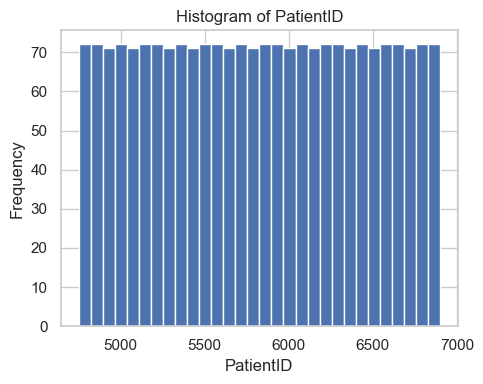

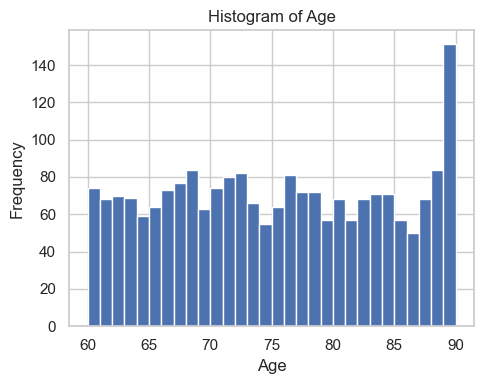

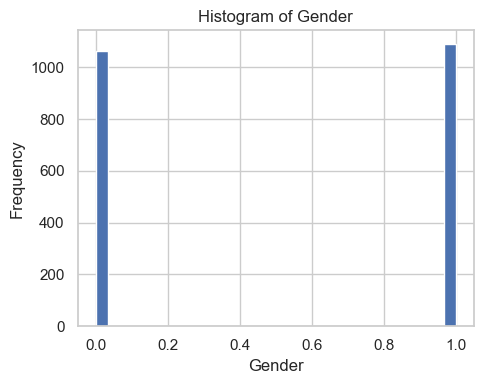

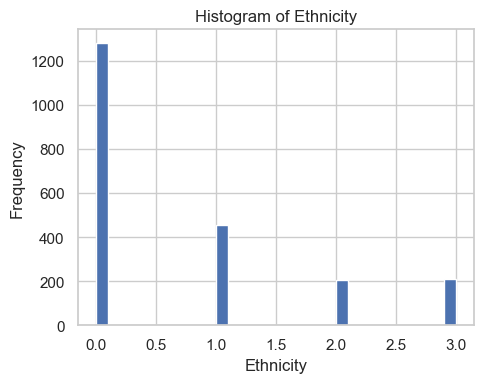

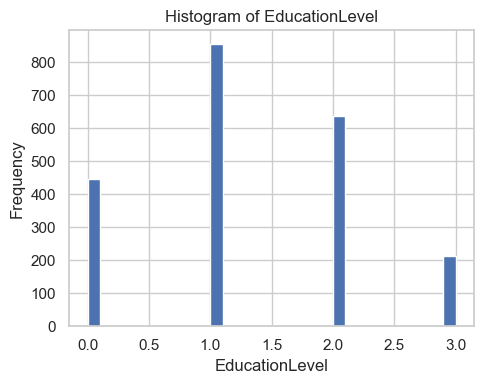

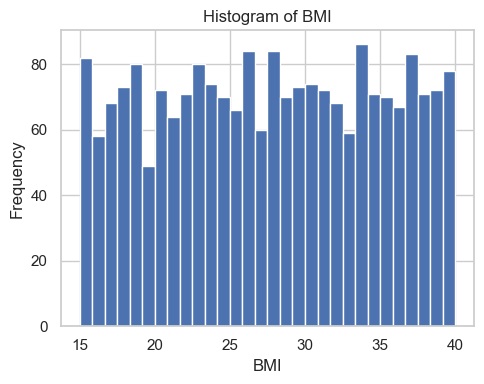

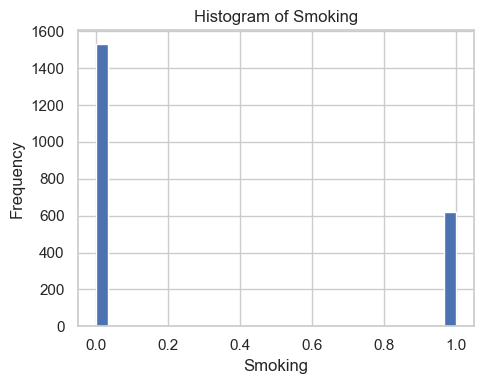

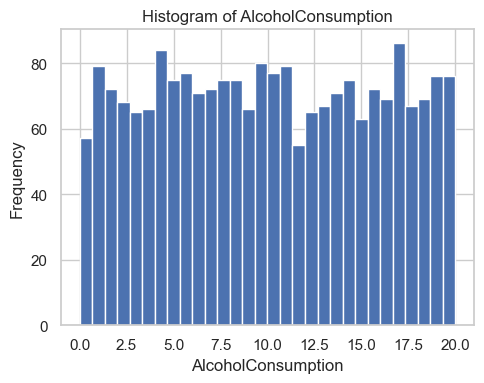

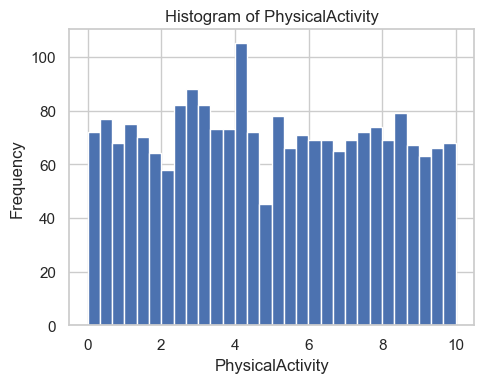

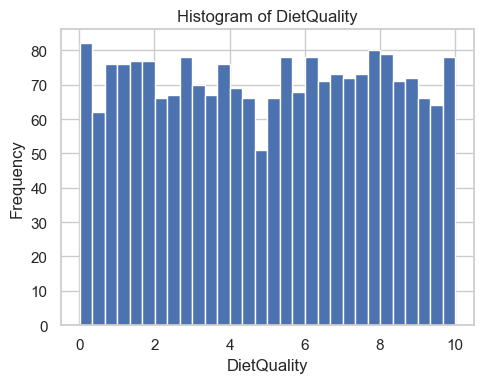

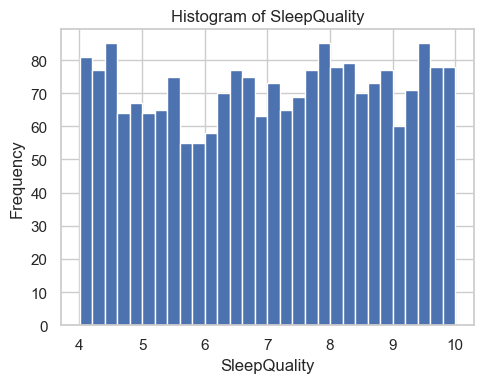

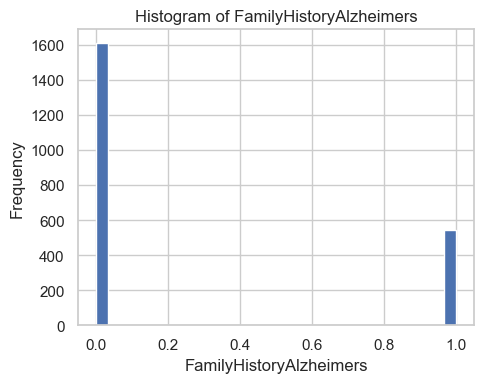

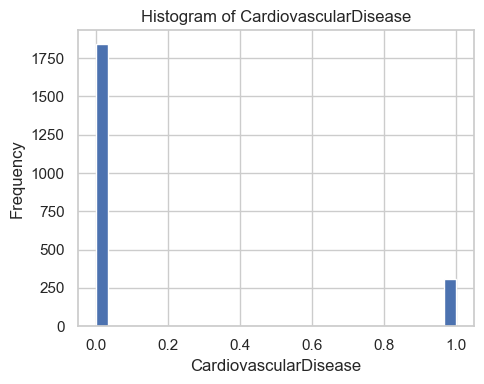

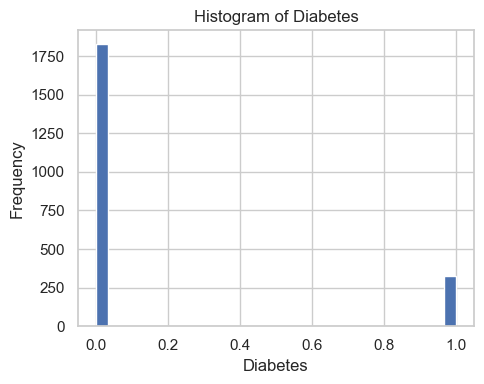

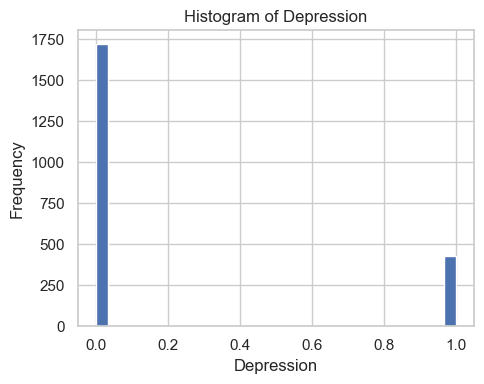

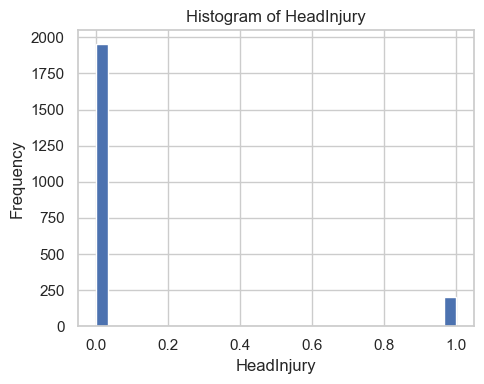

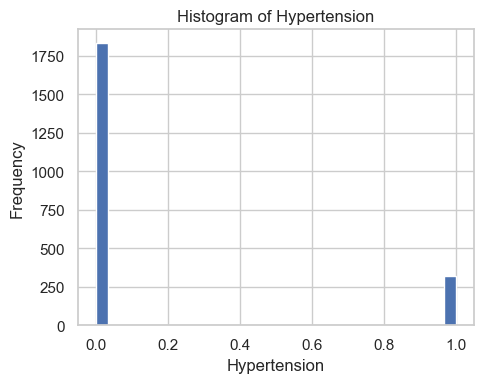

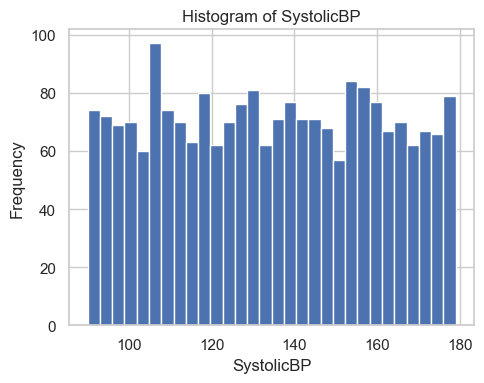

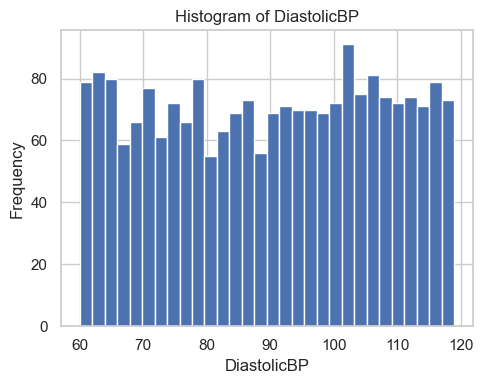

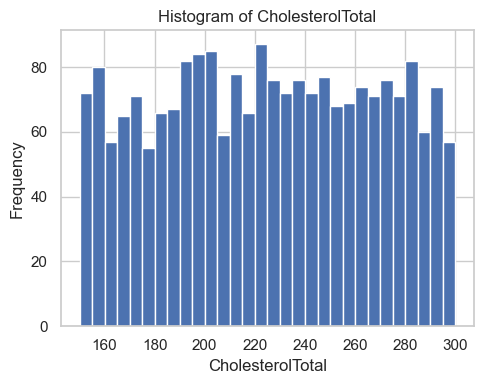

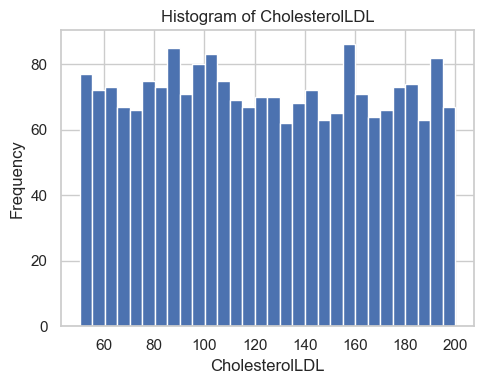

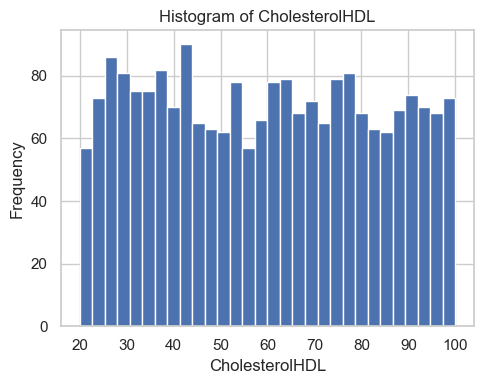

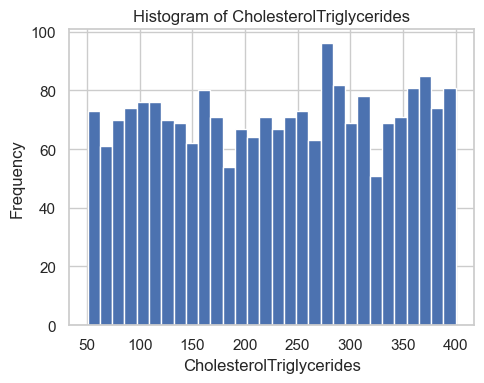

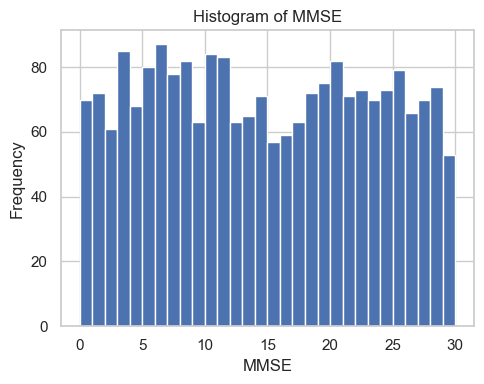

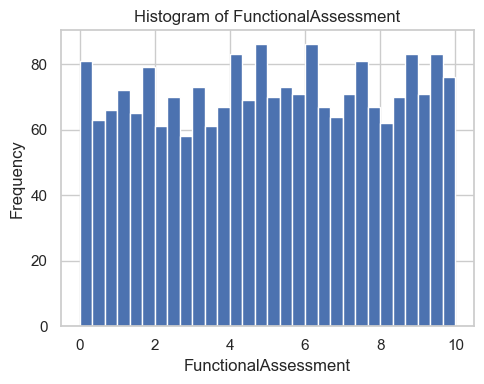

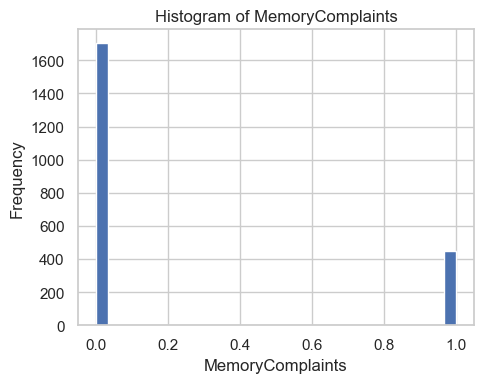

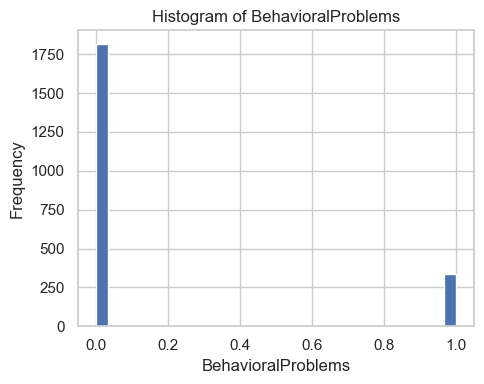

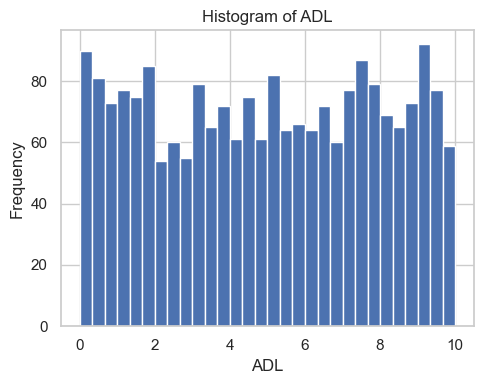

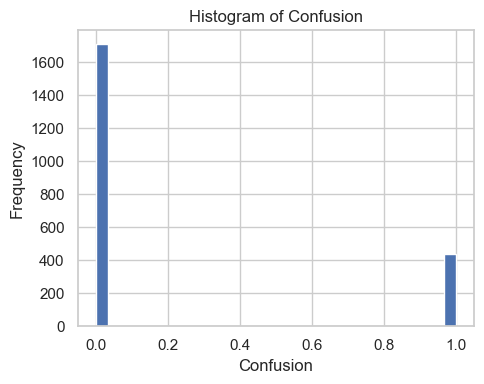

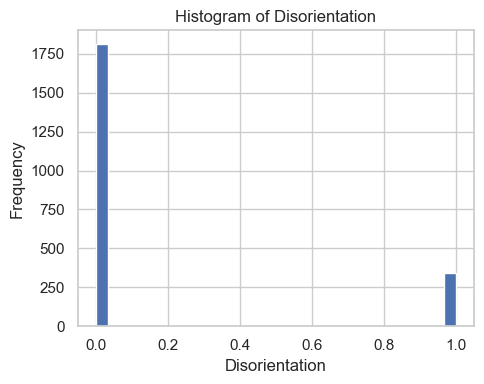

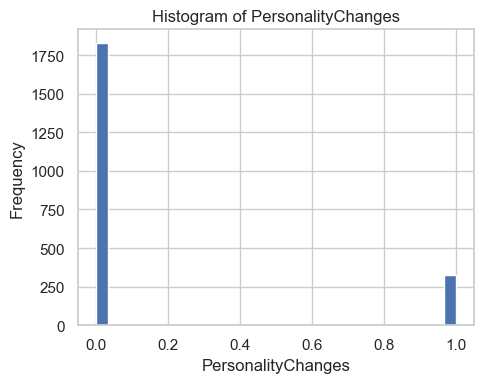

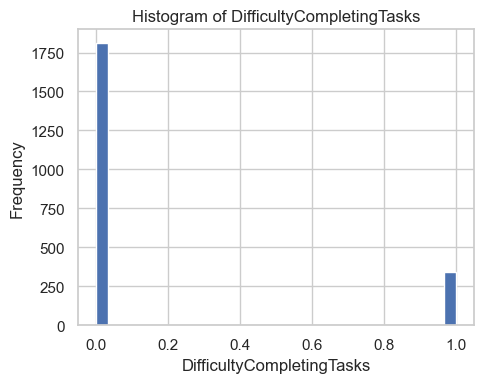

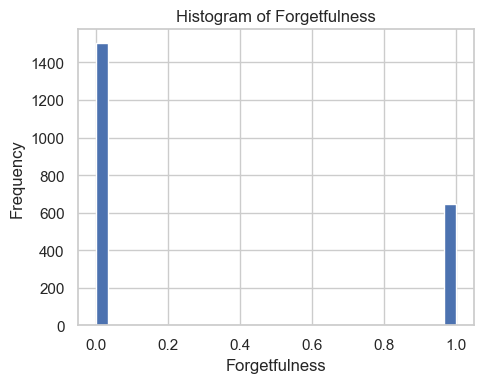

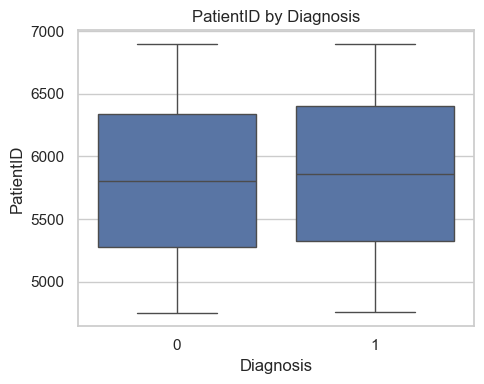

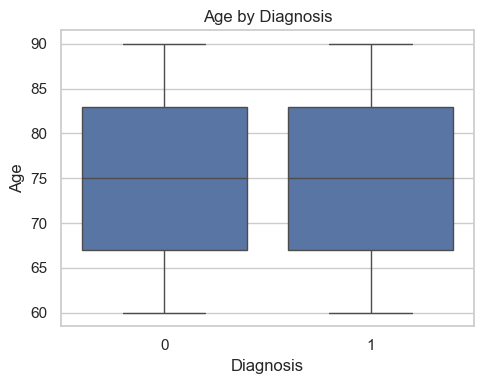

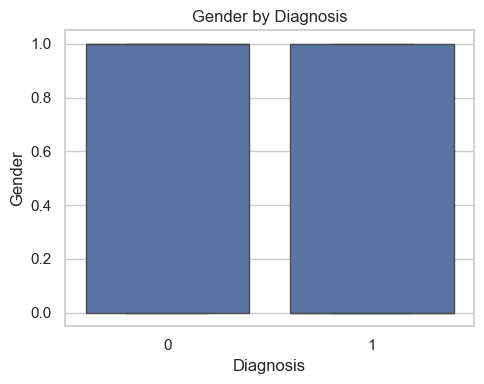

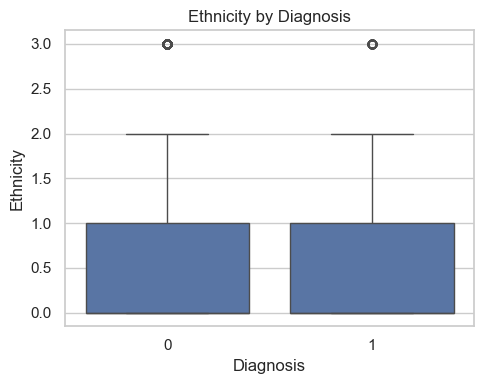

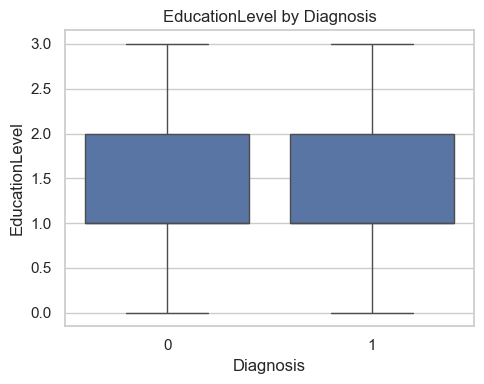

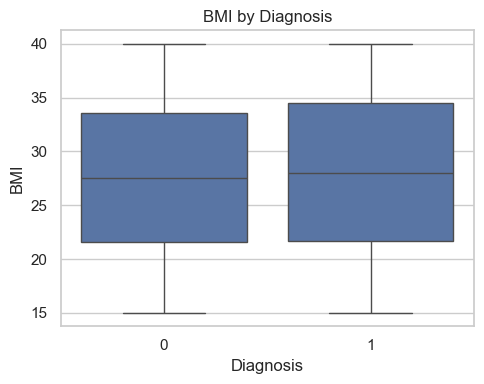

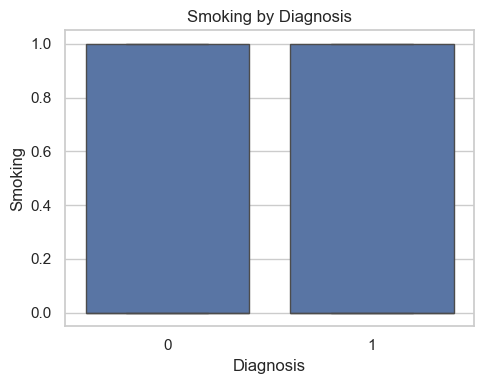

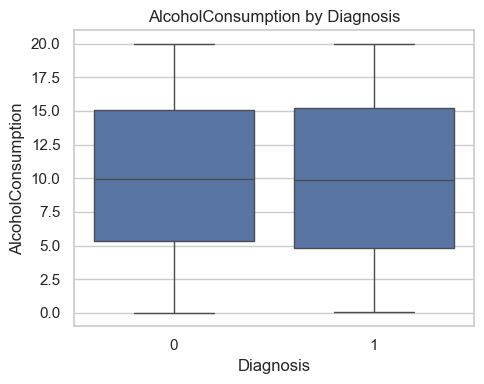

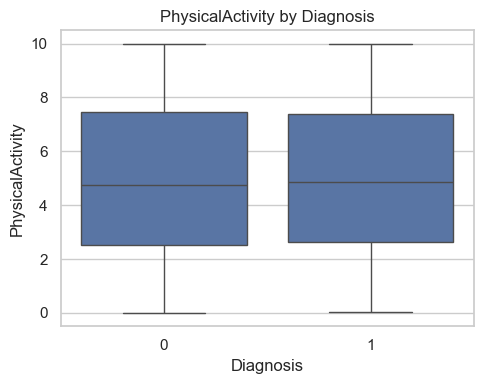

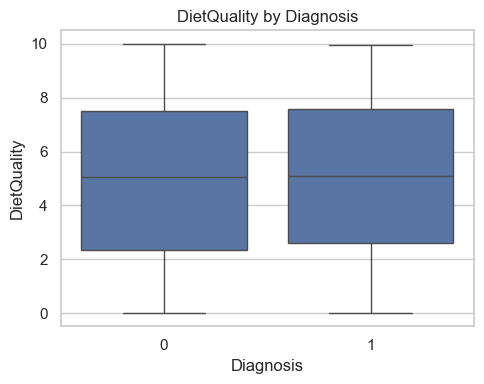

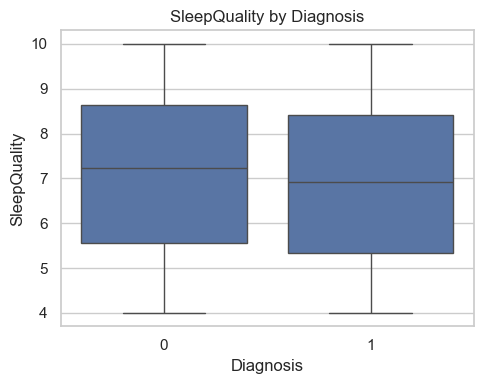

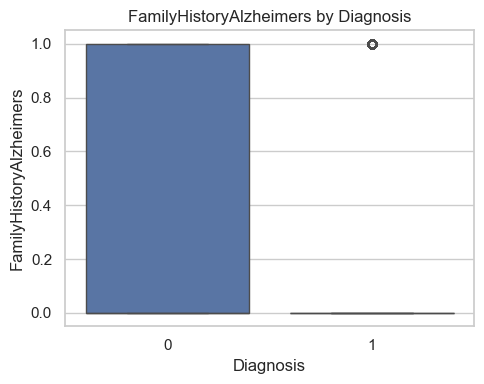

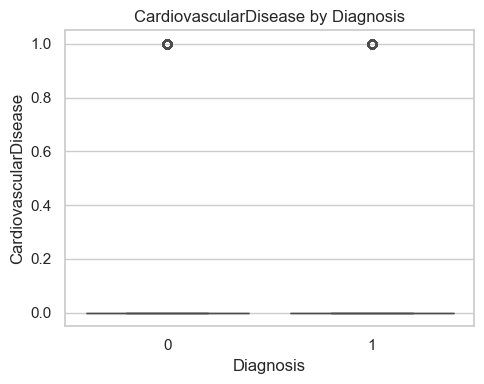

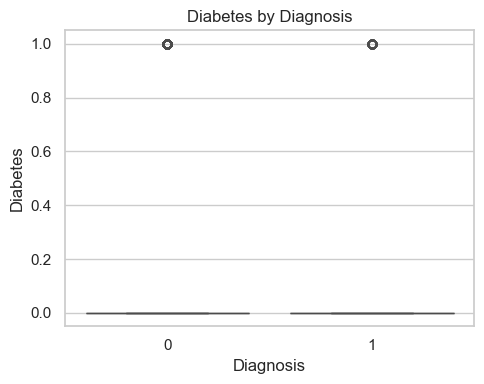

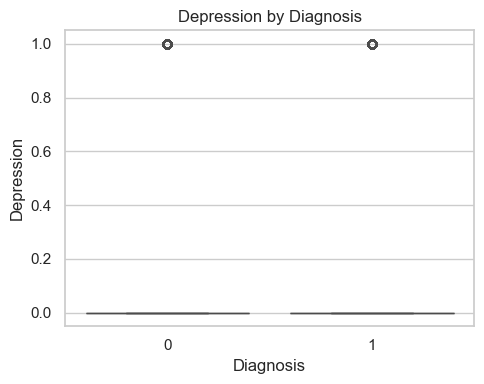

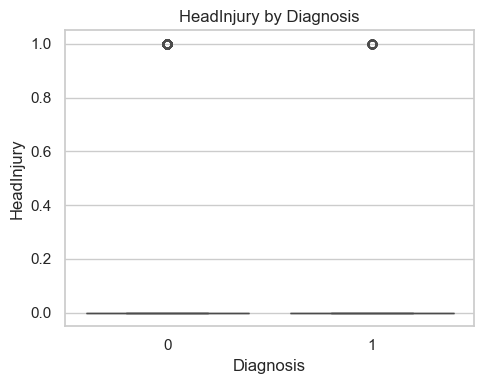

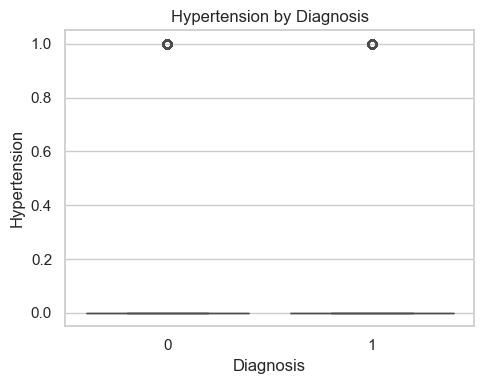

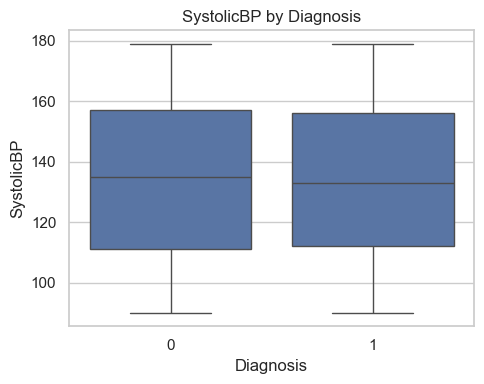

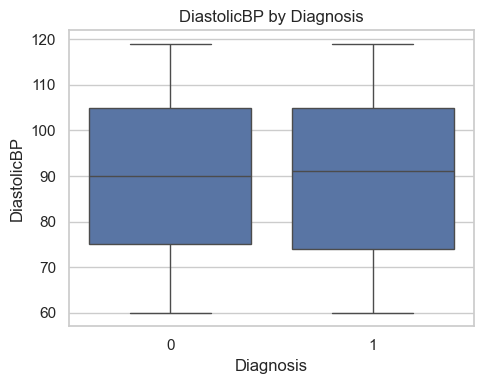

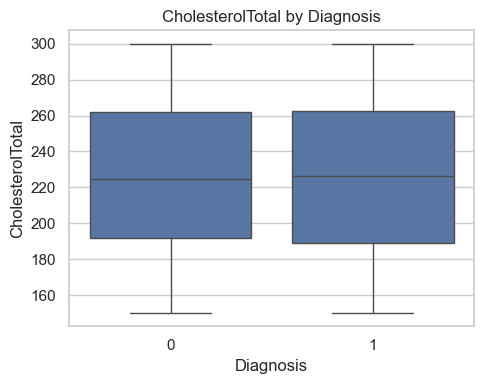

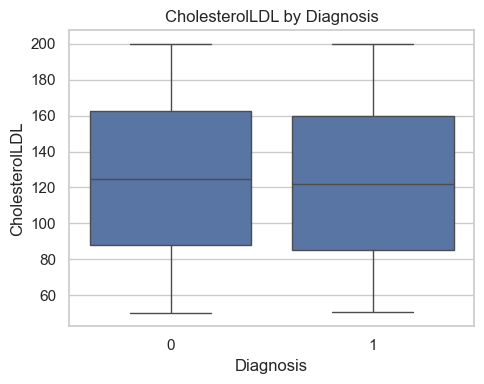

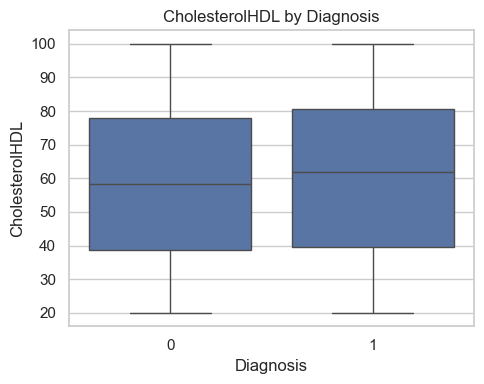

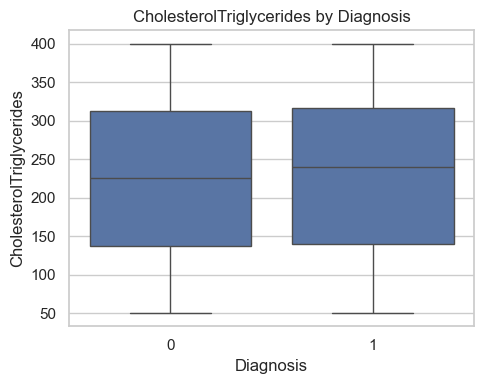

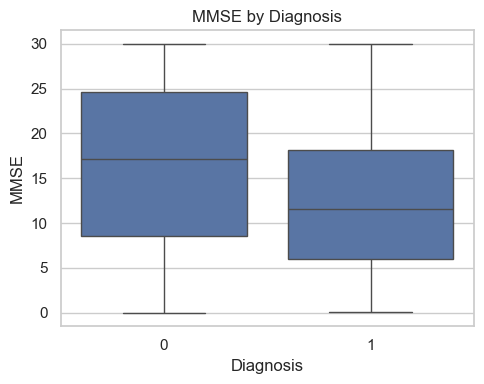

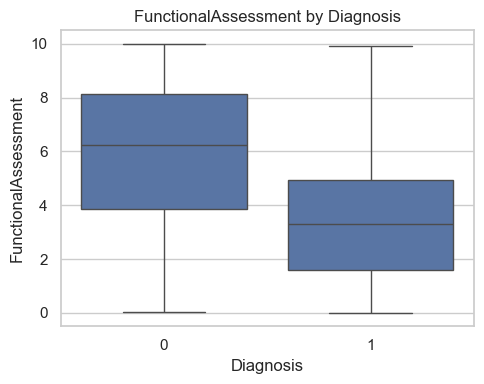

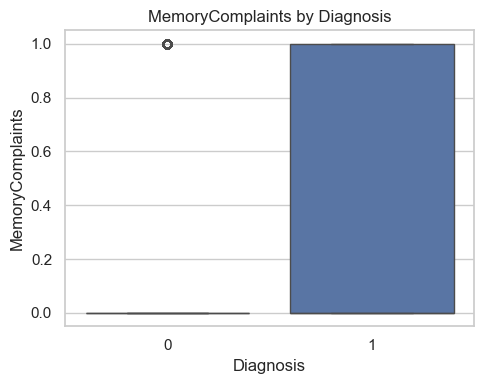

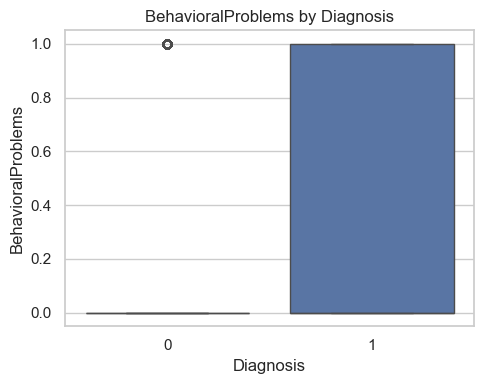

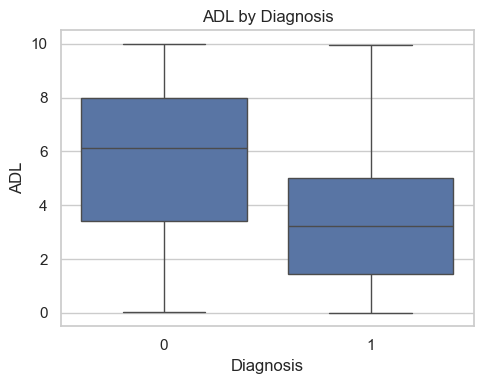

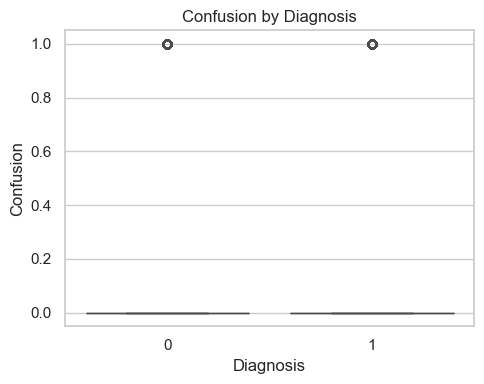

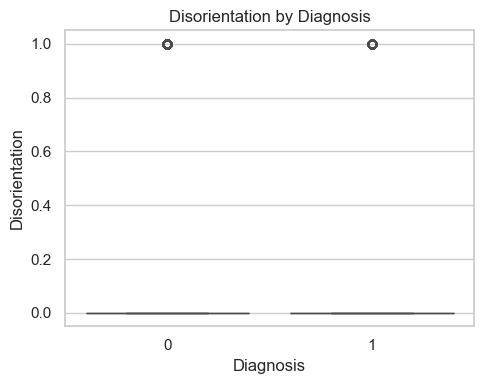

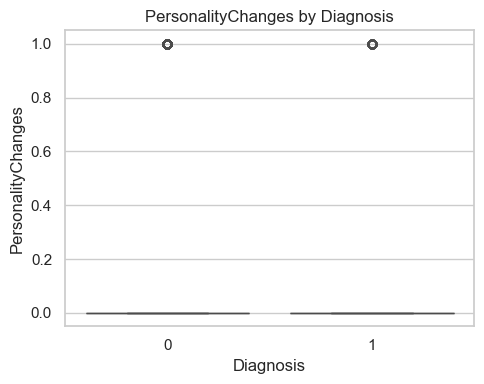

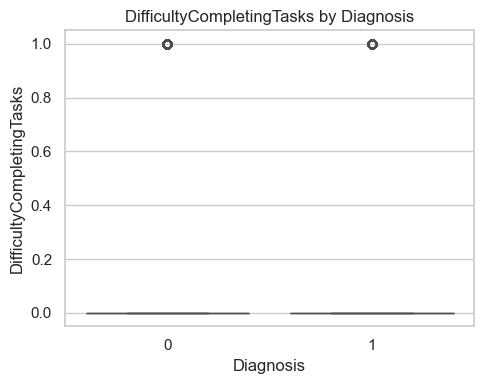

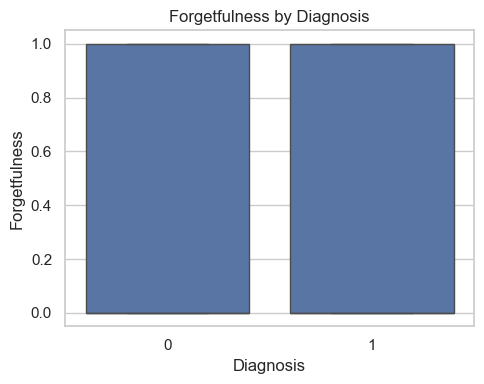

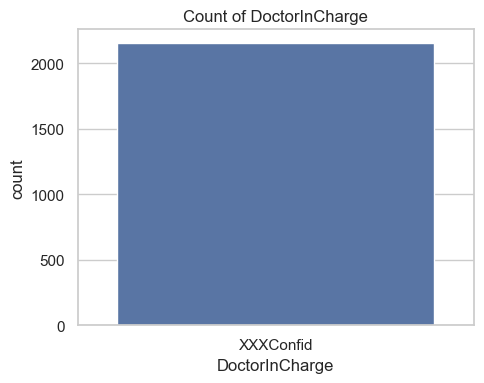

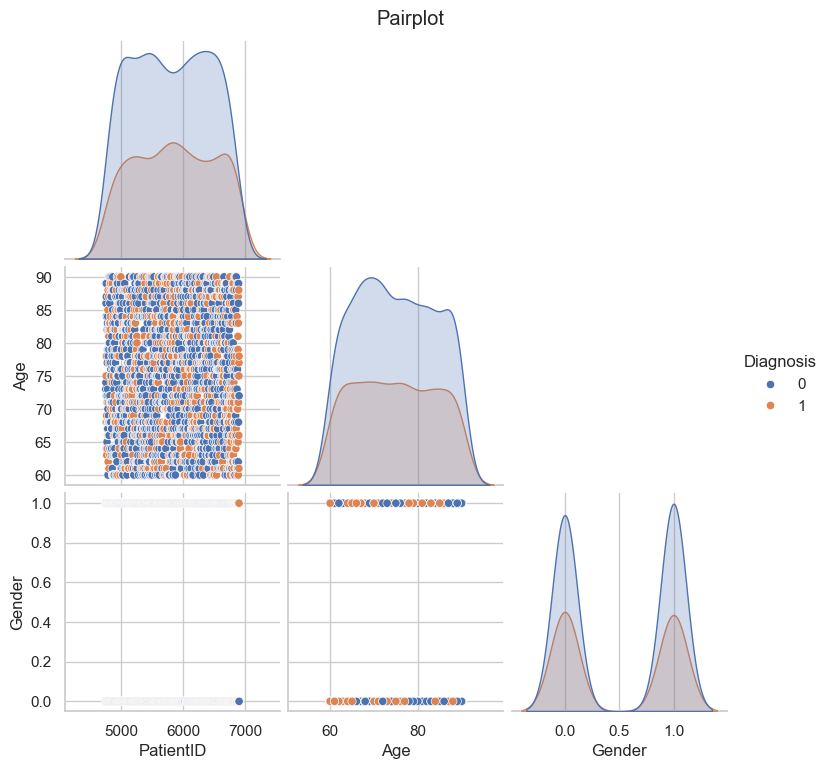

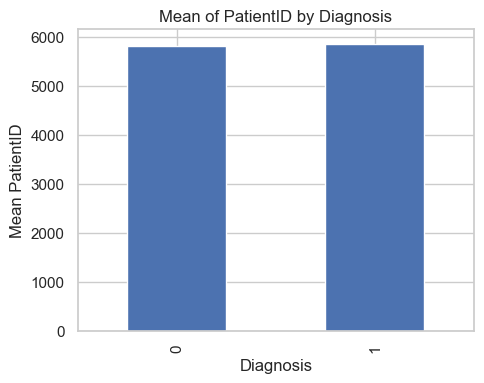

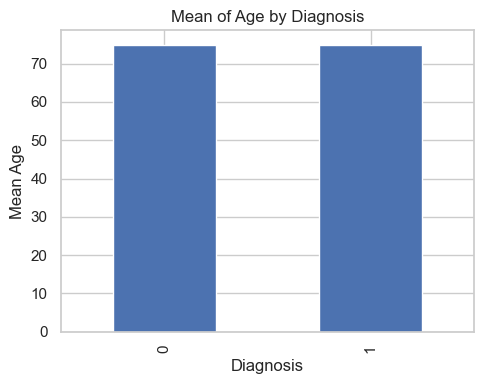

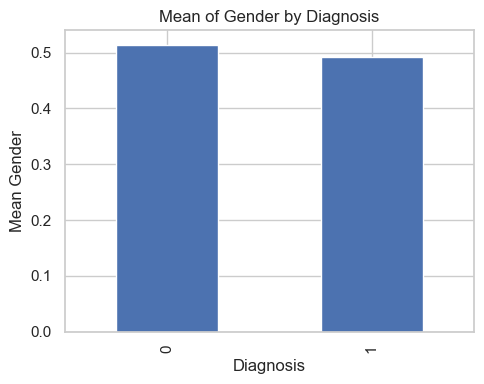

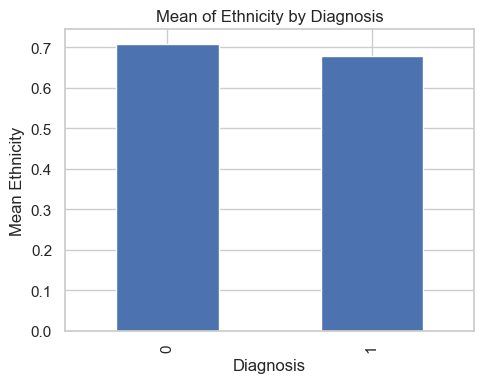

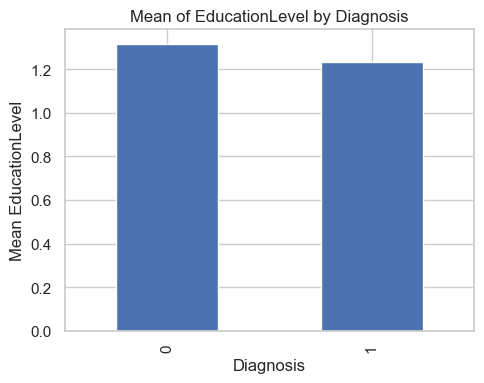

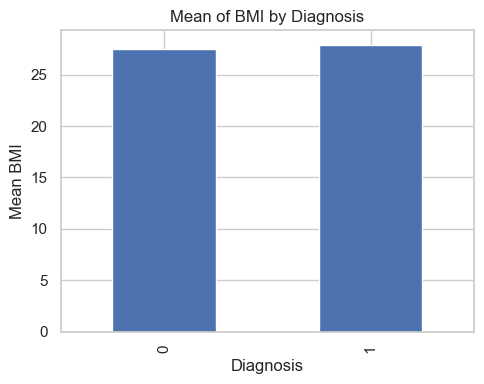

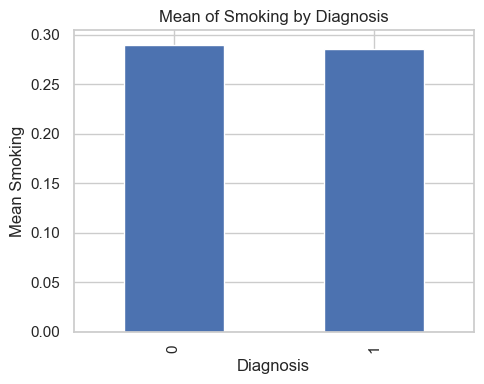

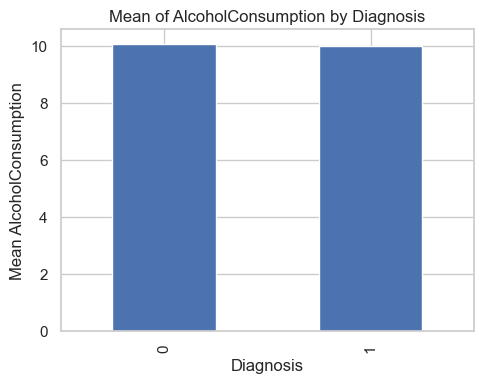

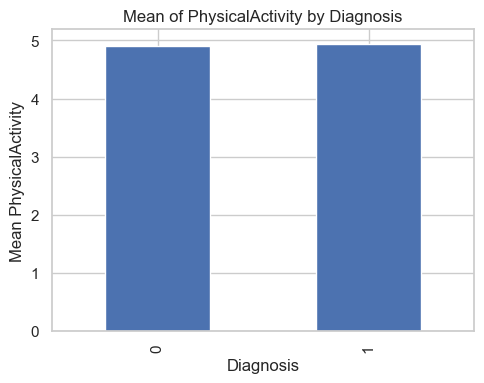

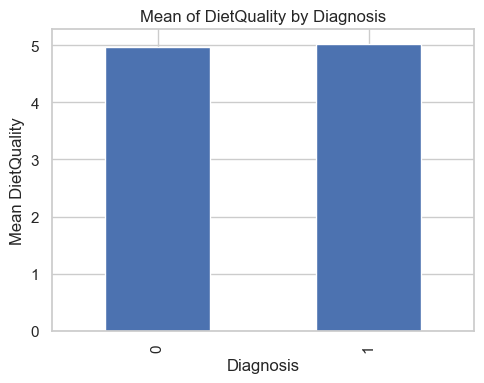

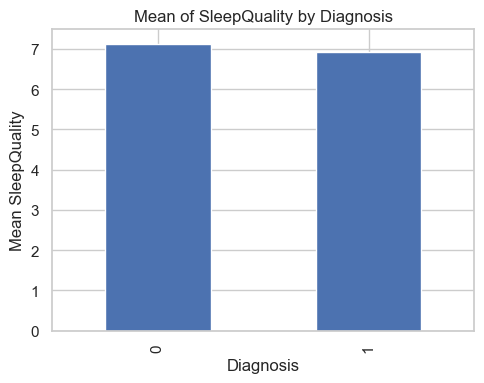

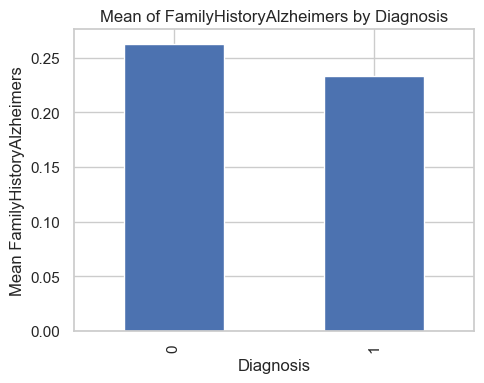

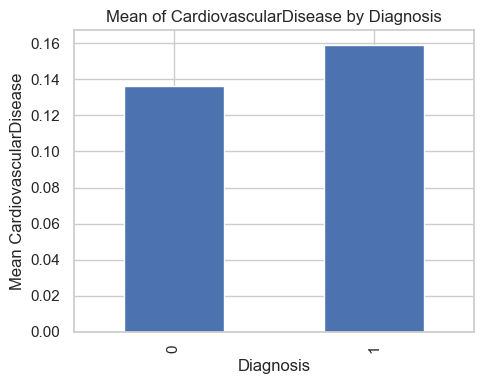

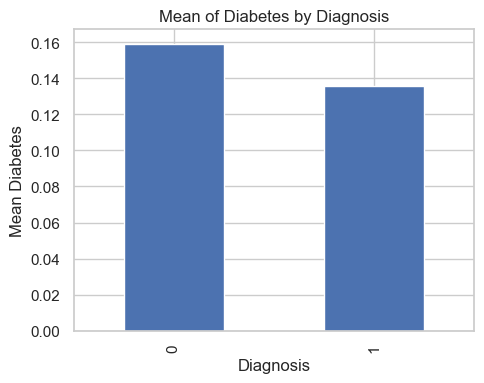

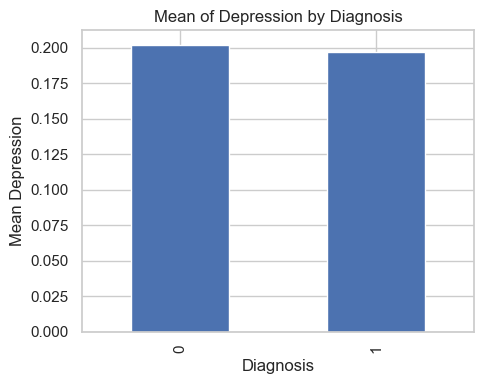

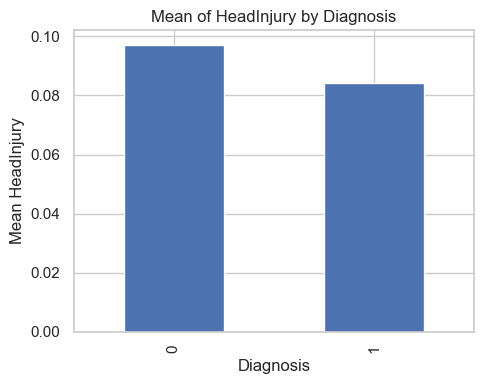

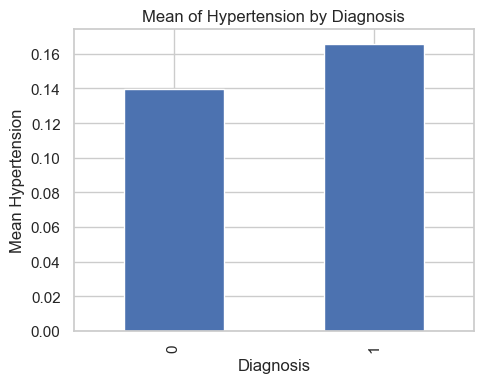

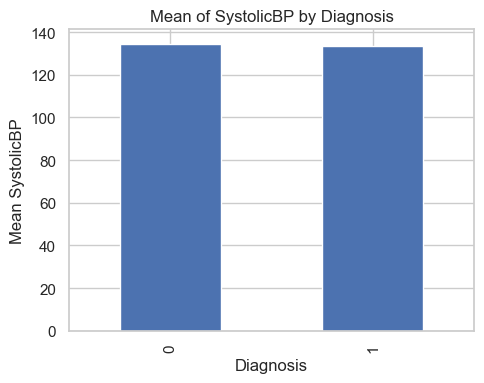

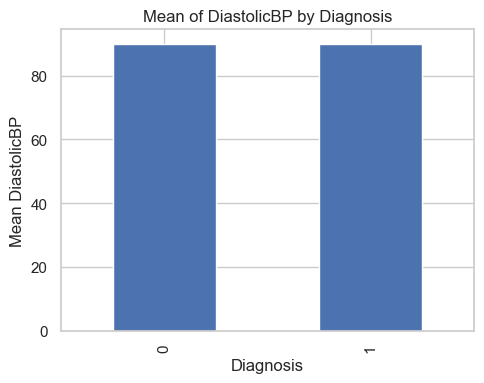

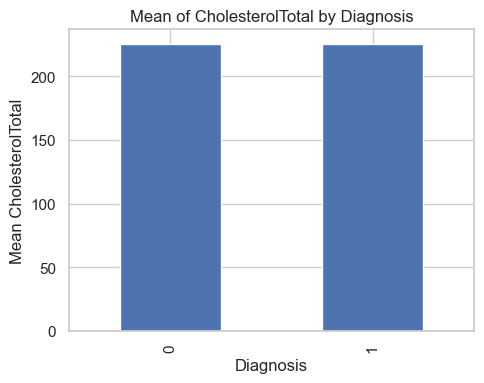

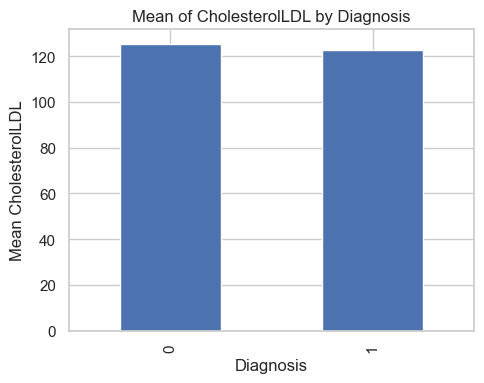

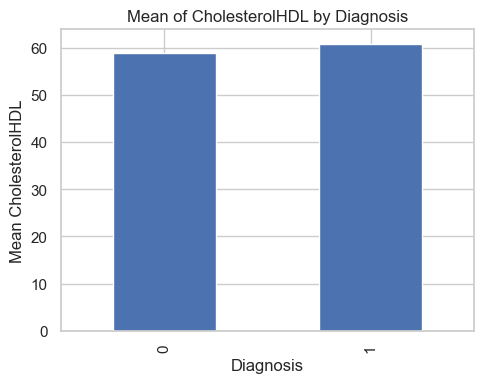

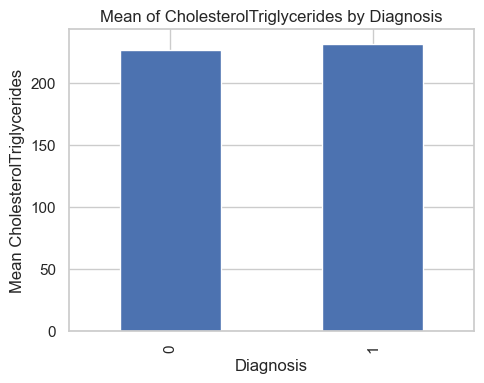

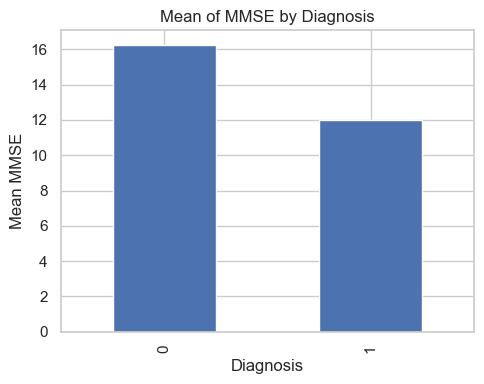

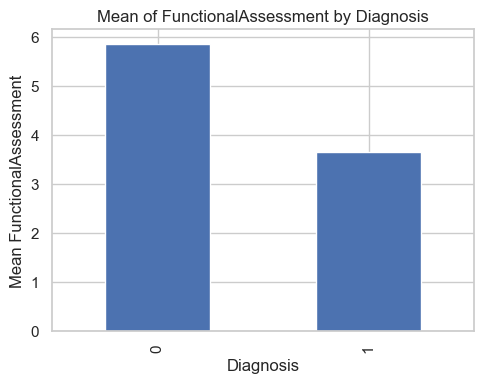

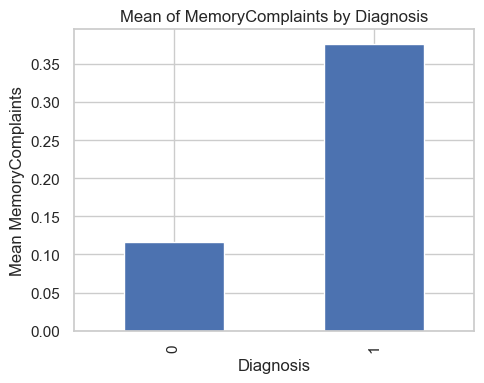

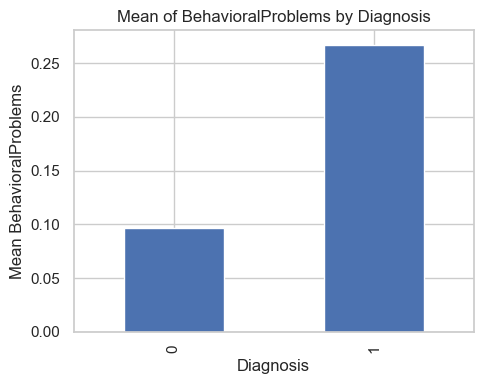

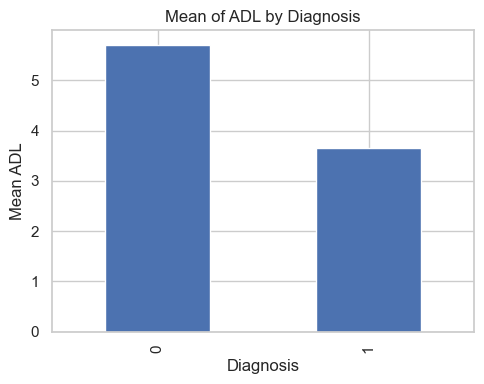

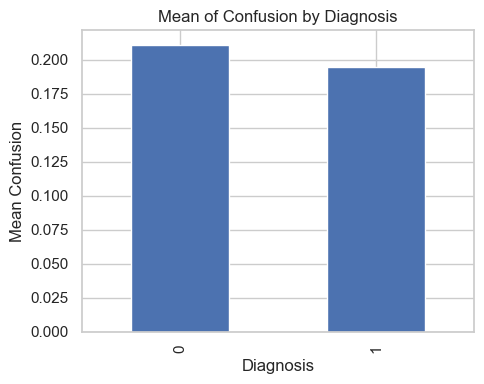

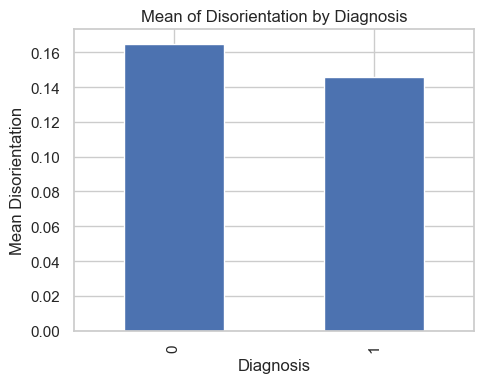

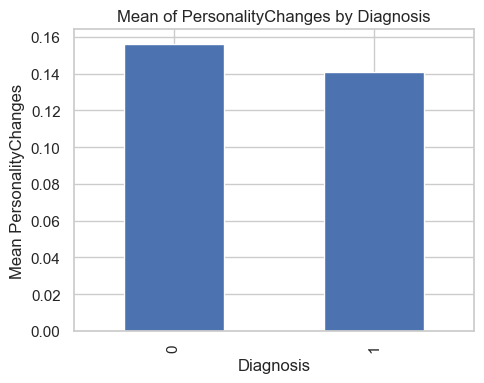

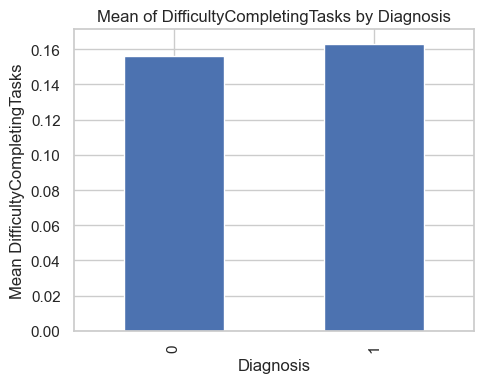

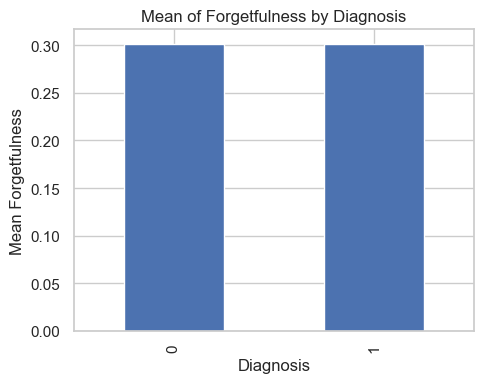

In [6]:
generate_basic_eda_plots(df, class_col='Diagnosis')

In [7]:
y = df['Diagnosis']

# Dropping columns that don't contain useful info for the models
X = df.drop(columns=['PatientID', 'DoctorInCharge', 'Diagnosis'])

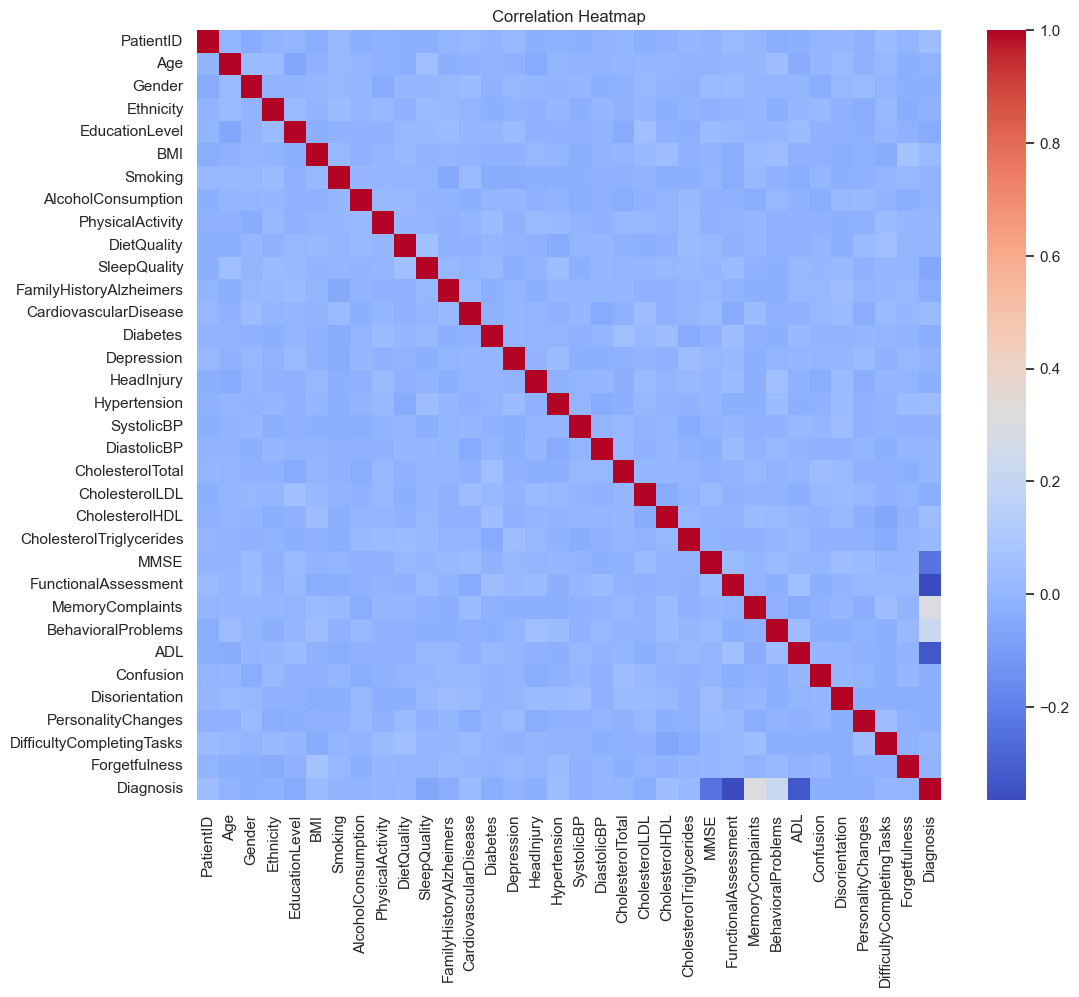

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix, to look for multicollinearity
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

Little correlation so input is ready for the model, no real multicollinearity

<Axes: title={'center': 'Diagnosis Class Distribution'}, xlabel='Diagnosis'>

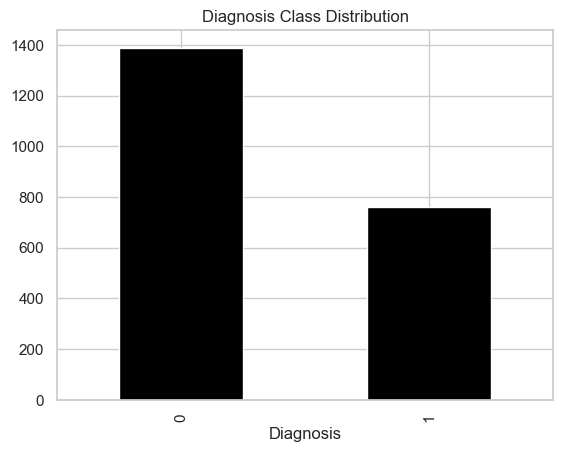

In [9]:
# check if classes are imbalanced
df['Diagnosis'].value_counts().plot(kind='bar', title='Diagnosis Class Distribution', color='black')

The diagnosis distribution in the dataset is approxamitely 1400 (no alzheimers) to 800 (alzheimers), which means one class makes up about 64% and the other about 36%. While this is not extremely imbalanced, it still introduces some risk that a logistic regression model may hesitate to diagnose alzheimers. This can lead to higher overall accuracy but poor performance (low recall or precision) on the minority class, which is often more important in medical predictions like Alzheimer's. To counter this dilemma, we have decided to implement resampling.

In [10]:
# one hot encoding to get numerical data
X = pd.get_dummies(X, drop_first=True)

# Logistic Regression Model

Oversampling: duplicates or synthetically creates more observations

This will make the data balanced to avoid bias in the model towards non-alzheimer diagnosis

In [13]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# train-test split before oversampling to avoid leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)

# apply random oversampling
ros = RandomOverSampler(random_state=10)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# check new class distribution
from collections import Counter
print("Before:", Counter(y_train))
print("After: ", Counter(y_resampled))


Before: Counter({0: 1111, 1: 608})
After:  Counter({0: 1111, 1: 1111})


LogisticRegressionCV is used to automatically find the best regularization strength (C) using 5-fold cross-validation

class_weight='balanced' may be unnecessary after resampling, but it is there just in case

liblinear solver permits the use of L2 regularization, and increased max_iter was increased to make sure it converges.

In [14]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(
    cv=5,
    penalty='l2',  # use 'l1' for Lasso-like feature selection
    solver='liblinear',  # 'liblinear' supports both l1 and l2
    scoring='accuracy',
    class_weight = 'balanced',
    max_iter=1000
)

model.fit(X_resampled, y_resampled)
print("Best C value (inverse of regularization strength):", model.C_[0])

Best C value (inverse of regularization strength): 0.3593813663804626


In [15]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       278
           1       0.68      0.82      0.74       152

    accuracy                           0.80       430
   macro avg       0.78      0.81      0.79       430
weighted avg       0.82      0.80      0.80       430



In [17]:
from sklearn.metrics import f1_score, roc_auc_score

print("F1 score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

F1 score: 0.7440476190476191
ROC AUC: 0.8050691026126466


### Evaluation Metrics and Formulas

Accuracy measures the overall correctness of the model:  
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$  
where TP = True Positives, TN = True Negatives, FP = False Positives, FN = False Negatives.

Precision tells us, out of all predicted positives, how many were actually positive:  
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Recall (also called Sensitivity) tells us, out of all actual positives, how many the model correctly identified:  
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

F1 Score is the harmonic mean of precision and recall, balancing both metrics into one number:  
$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

ROC AUC (Receiver Operating Characteristic - Area Under Curve) measures how well the model separates the classes across all classification thresholds.

- A value of 1 means perfect separation.
- A value of 0.5 means no better than random guessing.
- Higher values indicate better model performance at distinguishing positive from negative cases.


### Model Performance Assessment

The optimized logistic regression model achieved an **accuracy of 80%**, indicating solid overall performance.

- **Class 0 (No Alzheimer’s)**: Precision = 0.89, Recall = 0.79 → The model is strong at correctly identifying patients **without** Alzheimer’s.
- **Class 1 (Alzheimer’s)**: Precision = 0.68, Recall = 0.82 → It’s less precise but **better at catching actual Alzheimer’s cases** (high recall).
- **F1 Score (Macro Average)**: 0.78 → Shows a good balance between precision and recall across both classes.
- **ROC AUC = 0.83** → The model has a strong ability to distinguish between Alzheimer’s and non-Alzheimer’s cases.

**Conclusion**: The model performs well, especially in detecting Alzheimer’s patients (high recall). Further gains might come from feature selection, advanced preprocessing, or testing non-linear models like random forests or gradient boosting.


# Explanations

In [18]:
import pandas as pd

# Get coefficients
coeffs = pd.Series(model.coef_[0], index=X.columns)
print(coeffs.sort_values(ascending=False))

MemoryComplaints             2.388109
BehavioralProblems           2.169886
Hypertension                 0.262399
CardiovascularDisease        0.164663
Diabetes                     0.117186
DifficultyCompletingTasks    0.098557
Forgetfulness                0.076321
Depression                   0.055679
DietQuality                  0.039541
PhysicalActivity             0.039404
Ethnicity                    0.020237
CholesterolHDL               0.007285
SystolicBP                   0.006213
DiastolicBP                  0.004382
CholesterolTotal             0.002918
CholesterolTriglycerides     0.001605
BMI                         -0.000566
Age                         -0.000955
CholesterolLDL              -0.001054
AlcoholConsumption          -0.006752
SleepQuality                -0.022063
Gender                      -0.041546
EducationLevel              -0.065235
MMSE                        -0.087113
PersonalityChanges          -0.097231
Confusion                   -0.145013
Disorientati

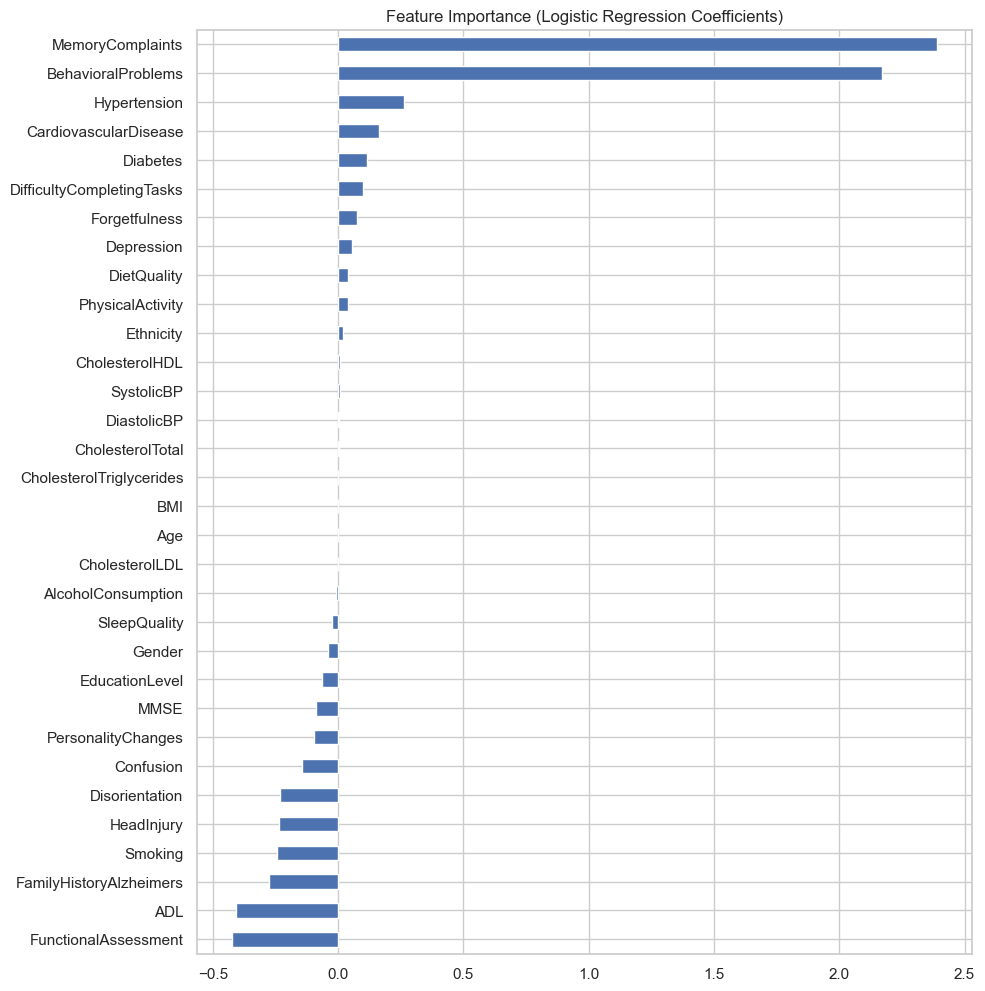

In [19]:
coeffs.sort_values().plot(kind='barh', figsize=(10, 12))
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

### Simple Coefficient Analysis

- **Memory complaints** and **behavioral problems** are the strongest signs of Alzheimer’s.
- **Hypertension** and **heart disease** slightly increase the chances too.
- **Good daily function (ADL, FunctionalAssessment)** strongly lowers the risk.
- **Head injury**, **smoking**, and **confusion** are linked to lower risk in this model, which might be due to how the data is structured.
- Most other features (like cholesterol, age, physical activity) don’t have much impact here.

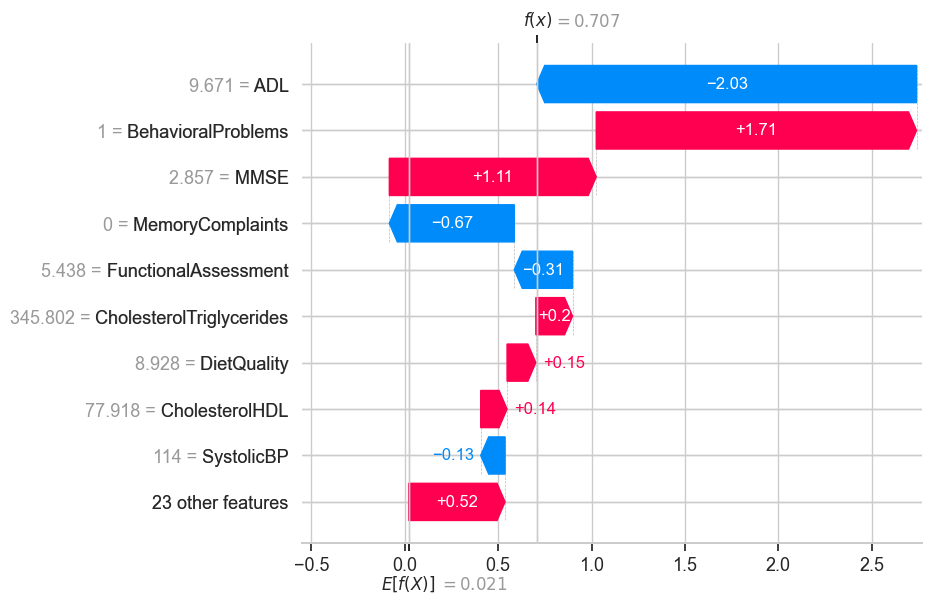

In [22]:
import shap

# Explainer for the trained logistic regression model
explainer = shap.LinearExplainer(model, X_resampled, feature_perturbation="interventional")

# Choose one sample to explain (Chose the first patient from test set)
sample = X_test.iloc[0]

# Compute SHAP values for that sample (patient)
shap_values = explainer.shap_values(sample)

# Waterfall plot to show how features contribute to the prediction
shap.plots.waterfall(shap.Explanation(values=shap_values, 
                                     base_values=explainer.expected_value, 
                                     data=sample))


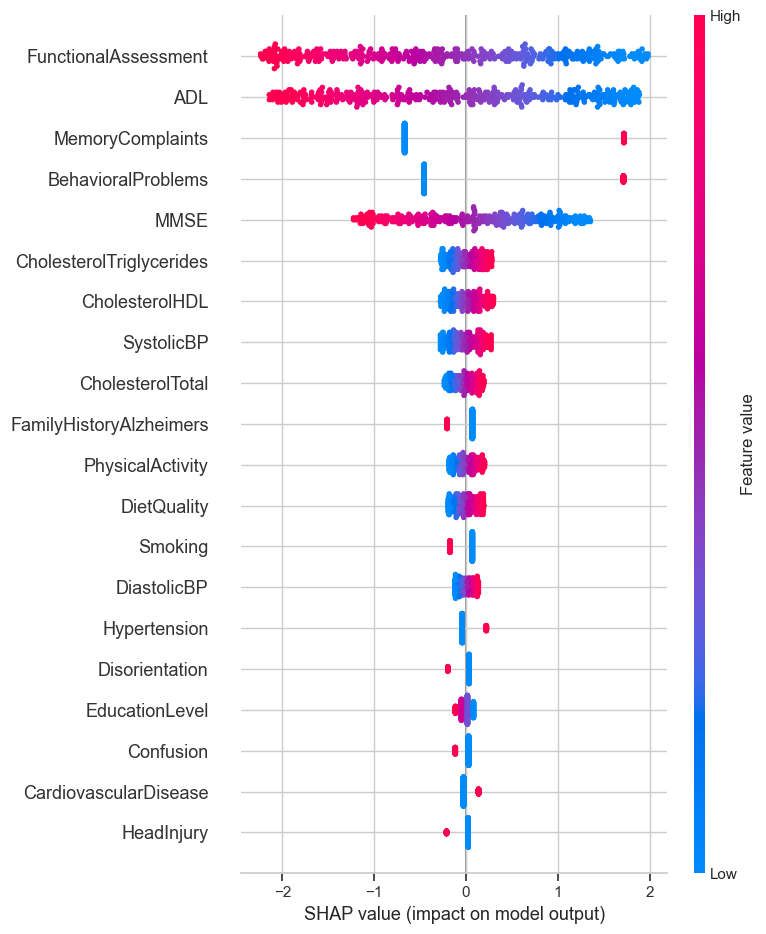

In [23]:
# Compute SHAP values for the whole test set
shap_values_all = explainer.shap_values(X_test)

# Summary plot showing feature importance and effect
shap.summary_plot(shap_values_all, X_test)


### SHAP Values Analysis

In the summary plot, FunctionalAssessment has the widest spread of SHAP values, ranging roughly from -2 to +2, which means it has the strongest impact on the model’s predictions. Points on the left (negative SHAP values) show that high values of FunctionalAssessment push the prediction toward class 0 (no Alzheimer’s), while points on the right (positive SHAP values) mean low values push the prediction toward class 1 (Alzheimer’s). The red and blue colors represent the feature’s actual value: red means high FunctionalAssessment scores, and blue means low scores. So, high FunctionalAssessment lowers the chance of Alzheimer’s, and low FunctionalAssessment increases it.

**Significant Contributors to No Alzheimer's Diagnosis:**
- High FunctionalAssessment score
- High ADL value
- High MMSE score


**Significant Contributors to Alzheimer's Diagnosis:**
- Low FunctionalAssessment score
- Low ADL value
- Occurence of memory complaints
- Behavioral problems
- Low MMSE score


### Fairness Metrics

Now, let us look at the subgroups according to Gender, Ethnicity and Education level to assess the fairness of our model. We will consider the metrics Group Fairness and Equalized Odds as defined in the lectures. 


In [24]:
fairness_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred
}, index=y_test.index)

fairness_df['Gender'] = df.loc[y_test.index, 'Gender']
fairness_df['Ethnicity'] = df.loc[y_test.index, 'Ethnicity']
fairness_df['EducationLevel'] = df.loc[y_test.index, 'EducationLevel']

In [25]:
def print_acceptance_rates(fairness_df, group_col):
    print(f"\nAcceptance Rates by {group_col}:")
    for group in sorted(fairness_df[group_col].unique()):
        rate = fairness_df[fairness_df[group_col] == group]['y_pred'].mean()
        print(f"  {group_col}={group}: {rate:.3f}")

for col in ['Gender', 'Ethnicity', 'EducationLevel']:
    print_acceptance_rates(fairness_df, col)


Acceptance Rates by Gender:
  Gender=0: 0.433
  Gender=1: 0.423

Acceptance Rates by Ethnicity:
  Ethnicity=0: 0.442
  Ethnicity=1: 0.424
  Ethnicity=2: 0.387
  Ethnicity=3: 0.381

Acceptance Rates by EducationLevel:
  EducationLevel=0: 0.521
  EducationLevel=1: 0.429
  EducationLevel=2: 0.339
  EducationLevel=3: 0.476


I would argue that our model is fair according to Group Fairness. The acceptance rates by gender and ethnicity are fairly close. There is no linear ascent or descent in acceptance raise as the education level rises, although the rate is slightly higher for the subgroup with no education and this could be a fairness concern and further investigation might be required as to determine if these differences are meaningful in the context of the dataset.

In [26]:
def print_equalized_odds(fairness_df, group_col):
    print(f"\nEqualized Odds by {group_col}:")
    for group in sorted(fairness_df[group_col].unique()):
        group_data = fairness_df[fairness_df[group_col] == group]
        # True Positive Rate
        positives = group_data[group_data['y_true'] == 1]
        tpr = positives['y_pred'].mean() if not positives.empty else float('nan')
        # False Positive Rate
        negatives = group_data[group_data['y_true'] == 0]
        fpr = negatives['y_pred'].mean() if not negatives.empty else float('nan')
        print(f"  {group_col}={group}: TPR={tpr:.3f}, FPR={fpr:.3f}")

for col in ['Gender', 'Ethnicity', 'EducationLevel']:
    print_equalized_odds(fairness_df, col)


Equalized Odds by Gender:
  Gender=0: TPR=0.861, FPR=0.184
  Gender=1: TPR=0.781, FPR=0.239

Equalized Odds by Ethnicity:
  Ethnicity=0: TPR=0.782, FPR=0.223
  Ethnicity=1: TPR=0.867, FPR=0.232
  Ethnicity=2: TPR=0.900, FPR=0.143
  Ethnicity=3: TPR=1.000, FPR=0.161

Equalized Odds by EducationLevel:
  EducationLevel=0: TPR=0.860, FPR=0.235
  EducationLevel=1: TPR=0.833, FPR=0.241
  EducationLevel=2: TPR=0.744, FPR=0.153
  EducationLevel=3: TPR=0.875, FPR=0.231


The model is more sensitive but less specific for males, and less sensitive but more likely to make false diagnoses for females. This is potentially a fairness concern, suggesting that the model’s errors are distributed unequally by gender.

For ethnicity, the model is most sensitive (highest TPR) for “Other” and Asian groups. This could suggest the model works better for smaller/less represented groups, but may also be due to data imbalance or sample size. 

When we look at the education level, we observe no huge differences except the lower TPR for Bachelor’s group. This could potentially mean that people with a Bachelor’s degree are less likely to be detected by the model when they have the condition.